Have trained a classifier following https://blog.machinebox.io/how-anyone-can-build-a-machine-learning-image-classifier-from-photos-on-your-hard-drive-very-5c20c6f2764f using my own bird data. Achieved an accuracy of 88% - but the first time I ran the script (different random selection of images) accuracy was about 92%, so clearly I am very sensitive to the images randomly selected and should add more images:
```
Correct:    180
Incorrect:  23
Errors:     0
Accuracy:   88.66995073891626%
```

https://machineboxio.com/docs/classificationbox

classificationbox is online learning (supervised learning), it works also with little data but it build the classifier function so it needs more data. for my bird monirtoring project my 2 classes would be bird/no_bird, and I just post the image data

Classifiers can be made to help solve a wide range of example use cases, for example:

* Learn about how your company is perceived by grouping tweets into positive and negative
* Automatically group photos of cats and dogs
* Group emails into spam and non-spam categories
* Build a classifier to detect the language of a piece of text based on previously taught examples

```
sudo docker pull machinebox/classificationbox

sudo docker run -p 8080:8080 -e "MB_KEY=$MB_KEY" machinebox/classificationbox
```
http://localhost:8080/

In [1]:
import requests
import json
import base64
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

def base64_encode_image(image_path):
    """
    Takes the path to an image and returns the base64 encoded
    image data as a string.
    """
    with open(image_path, "rb") as f:
        image_data = base64.b64encode(f.read()).decode('ascii')
    return image_data

In [2]:
IP =  'localhost'
PORT = '8080'
CLASSIFIER = 'classificationbox'

Lets list my models

In [17]:
MODELS_LIST_URL = 'http://{}:{}/{}/models'.format(IP, PORT, CLASSIFIER)

models_query = requests.get(MODELS_LIST_URL).json()

if models_query['success']:
    for model in models_query['models']:
        print(model['id'], model['name'])

image_classifier_1 Cat/monkey classifier
5b0ce5d8023d4e35 5b0ce5d8023d4e35


I want the model which was generated by the GO script on my bird data

In [8]:
MODEL_ID = models_info['models'][0]['id']
MODEL_ID

'5b0ce5d8023d4e35'

In [9]:
MODEL_CREATION_URL = 'http://{}:{}/{}/models'.format(IP, PORT, CLASSIFIER)
MODEL_TEACH_URL = 'http://{}:{}/{}/models/{}/teach'.format(IP, PORT, CLASSIFIER, MODEL_ID)
MODEL_STATS_URL = 'http://{}:{}/{}/models/{}/stats'.format(IP, PORT, CLASSIFIER, MODEL_ID)
MODEL_PREDICT_URL = 'http://{}:{}/{}/models/{}/predict'.format(IP, PORT, CLASSIFIER, MODEL_ID)

Now lets see the stats on this model

In [10]:
model_stats = requests.get(MODEL_STATS_URL).json()
model_stats

{'success': True,
 'predictions': 205,
 'examples': 812,
 'classes': [{'name': 'not_birds', 'examples': 411},
  {'name': 'birds', 'examples': 401}]}

Lets make a prediction on a bird image

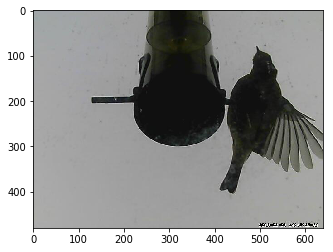

In [29]:
IMG_FILE = "bird.jpg"
FIG_SIZE = (6, 4)

img = plt.imread(IMG_FILE)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.imshow(img);

In [30]:
predict_data  = {
    "inputs": [
        {"key": "image", "type": "image_base64", "value": base64_encode_image(IMG_FILE)}]}

response = requests.post(MODEL_PREDICT_URL, json=predict_data).json()
response

{'success': True,
 'classes': [{'id': 'birds', 'score': 0.914466},
  {'id': 'not_birds', 'score': 0.085534}]}

In [31]:
def get_classes(classes):
    """Return the classes data."""
    return {class_result['id']: round(class_result['score'], 2)
            for class_result in classes}

In [34]:
classes = get_classes(response['classes'])
classes

{'birds': 0.91, 'not_birds': 0.09}

In [36]:
confidence = 0.8
for key, value in classes.items():
    if value >= confidence:
        print("{} with confidence {}".format(key, value))

birds with confidence 0.91


Great! Successful prediction. Now lets try the not bird

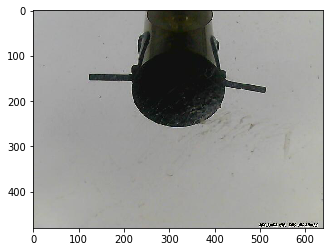

In [13]:
IMG_FILE = "not_bird.jpg"
FIG_SIZE = (6, 4)

img = plt.imread(IMG_FILE)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.imshow(img);

In [14]:
predict_data  = {
    "inputs": [
        {"key": "image", "type": "image_base64", "value": base64_encode_image(IMG_FILE)}]}

requests.post(MODEL_PREDICT_URL, json=predict_data).json()

{'success': True,
 'classes': [{'id': 'not_birds', 'score': 0.516652},
  {'id': 'birds', 'score': 0.483348}]}

OK still correct, but obviously a close call

## Class
Make a class wrapper

In [15]:
CLASSIFIER = 'classificationbox'

class ClassificationboxEntity():
    """Perform an image classification."""

    def __init__(self, ip, port, camera_entity, model_id, model_name):
        """Initialise a classificationbox model entity."""
        self._base_url = "http://{}:{}/{}/".format(ip, port, CLASSIFIER)
        self._camera = camera_entity

        self._model_id = model_id
        self._model_name = model_name

        camera_name = camera_entity # split_entity_id(camera_entity)[1]
        self._name = "{} {} {}".format(
            CLASSIFIER, camera_name, model_name)
        
    @property
    def name(self):
        """Return the name of the sensor."""
        return self._name
    
    @property
    def device_state_attributes(self):
        """Return the classifier attributes."""
        return {
            'model_id': self._model_id,
            'model_name': self._model_name
            }
    

In [18]:
entities = []

if models_query['success']:
    for model in models_query['models']:
        camera_entity = 'mock_cam'
        entity = ClassificationboxEntity(IP, PORT, camera_entity, model['id'], model['name'])
        entities.append(entity)

In [24]:
entities[1].name

'classificationbox mock_cam 5b0ce5d8023d4e35'

In [25]:
entities[1].device_state_attributes

{'model_id': '5b0ce5d8023d4e35', 'model_name': '5b0ce5d8023d4e35'}